# Data Science for E-Commerce
This code is divided in three notebooks: 
- Exploratory analysis: ecommerce_exploratory.ipynb
- Sales predictions: ecommmerce_SARIMA.ipynb, with auxiliary function preprocess_data.py
- Insights from the data: ecommerce_insights.ipynb

This is the first part containing the exploratory analysis.

## Data exploration and cleaning
#### Import libraries and read data

In [1]:
# import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
# Read dataset 
data = pd.read_csv('ecommerce_data.csv')
data.shape

(130000, 10)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   InvoiceDate    130000 non-null  object 
 1   InvoiceNo      130000 non-null  object 
 2   StockCode      6646 non-null    object 
 3   Description    3693 non-null    object 
 4   Quantity       10426 non-null   float64
 5   InvoiceDate.1  130000 non-null  object 
 6   UnitPrice      130000 non-null  float64
 7   CustomerID     125418 non-null  float64
 8   Country        130000 non-null  object 
 9   Estore_id      130000 non-null  int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 9.9+ MB


In [4]:
# rename column Estore_id EstoreID for constistency
data = data.rename(columns={"Estore_id": "EstoreID"})
data.head(10)

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,InvoiceDate.1,UnitPrice,CustomerID,Country,EstoreID
0,2010-12-09 15:43:00,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1.0,2010-12-09 15:43:00,2.95,15329.0,United Kingdom,20
1,2011-12-09 09:07:00,581480,23355,HOT WATER BOTTLE KEEP CALM,12.0,2011-12-09 09:07:00,4.95,14441.0,United Kingdom,20
2,2011-12-07 12:55:00,581132,NaN,NaN,4.0,2011-12-07 12:55:00,4.95,17590.0,United Kingdom,1
3,2011-06-23 14:11:00,557892,NaN,NaN,2.0,2011-06-23 14:11:00,6.35,14534.0,United Kingdom,17
4,2011-01-25 14:01:00,542115,84992,NaN,1.0,2011-01-25 14:01:00,2.08,NaN,United Kingdom,6
5,2011-12-01 11:51:00,580024,35964,NaN,36.0,2011-12-01 11:51:00,0.39,15172.0,United Kingdom,32
6,2011-01-27 10:30:00,542277,21754,NaN,9.0,2011-01-27 10:30:00,5.95,14440.0,United Kingdom,9
7,2011-03-08 12:30:00,545979,NaN,RED RETROSPOT CHARLOTTE BAG,4.0,2011-03-08 12:30:00,0.85,12748.0,United Kingdom,3
8,2011-03-04 10:24:00,545590,21703,BAG 125g SWIRLY MARBLES,12.0,2011-03-04 10:24:00,0.42,15220.0,United Kingdom,15
9,2011-04-04 15:54:00,548893,22811,NaN,1.0,2011-04-04 15:54:00,5.79,NaN,United Kingdom,2


In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID,EstoreID
count,10426.000000,130000.000000,125418.000000,130000.000000
mean,11.338673,4.538586,13253.560358,16.508677
std,69.476431,32.374397,1363.410277,9.223470
min,-3167.000000,0.000000,12349.000000,1.000000
25%,1.000000,1.250000,12438.000000,9.000000
50%,4.000000,1.950000,12597.000000,17.000000
75%,12.000000,3.750000,13505.000000,24.000000
max,2400.000000,4161.060000,18287.000000,32.000000


- The data has 130.000 entries and 10 variables
- There are a lot of **missing values**. It might be possible to restore them from other available information (e.g. StockCode and Description should have a 1-1 relationship). If for a variable there are too many missing values that cannot be inferred the information becomes useless and then it's better to drop the variable. 
- Quantity has a min and max that differ greatly from the rest of the values, possible **outliers**.
- It looks like there is a **redundant column**, InvoiceDate.1. Check if is actually redundant and if so remove it. 
- The data has information for each single transaction  with no apparent order. I expect that there might be several items with the same invoice number (InvoiceNo) belonging to the same order as well as copies of the same invoice. Check if true.

#### Redundant information
There are two columns InvoiceDate and InvoiceDate.1 that looks identical. Let's check if they actually are. If so, we can drop 'InvoiceDate.1'.

In [6]:
comparison_column = np.where(data['InvoiceDate'] == data['InvoiceDate.1'], 1, 0)

if 0 in comparison_column:
    print('not identical')
else:
    print('identical')
    
data = data.drop(['InvoiceDate.1'], axis=1)

identical


In [7]:
data.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,EstoreID
0,2010-12-09 15:43:00,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1.0,2.95,15329.0,United Kingdom,20
1,2011-12-09 09:07:00,581480,23355,HOT WATER BOTTLE KEEP CALM,12.0,4.95,14441.0,United Kingdom,20
2,2011-12-07 12:55:00,581132,NaN,NaN,4.0,4.95,17590.0,United Kingdom,1
3,2011-06-23 14:11:00,557892,NaN,NaN,2.0,6.35,14534.0,United Kingdom,17
4,2011-01-25 14:01:00,542115,84992,NaN,1.0,2.08,NaN,United Kingdom,6


In [8]:
print('How many duplicate entries? {}'.format(data.duplicated().sum()))
data[data.duplicated()]

How many duplicate entries? 30818


,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,EstoreID
623,2011-11-25 14:25:00,578827,NaN,NaN,NaN,5.79,NaN,United Kingdom,32
1146,2011-07-18 15:56:00,560434,NaN,NaN,NaN,0.83,NaN,United Kingdom,5
1202,2011-11-18 15:59:00,577358,NaN,NaN,NaN,1.63,NaN,United Kingdom,18
2035,2011-09-02 09:38:00,565234,NaN,NaN,1.0,0.83,NaN,United Kingdom,2
3716,2011-09-22 13:31:00,567853,NaN,NaN,NaN,1.25,15484.0,United Kingdom,25
...,...,...,...,...,...,...,...,...,...
129991,2011-07-06 14:17:00,559145,NaN,NaN,NaN,4.95,17404.0,Sweden,19
129992,2011-08-25 15:22:00,564539,NaN,NaN,NaN,1.65,12715.0,Sweden,20
129993,2011-11-06 13:11:00,574690,NaN,NaN,NaN,3.75,12638.0,Sweden,12
129997,2011-11-18 16:17:00,C577363,NaN,NaN,NaN,2.89,12697.0,Sweden,16


There are a 30.818 rows that are duplicates. Let's drop them.

In [9]:
data.drop_duplicates(inplace = True)
data.shape[0]

99182

After removing the duplicates we are left with 99.182 unique entries.

#### Missing values

In [10]:
# Count missing values in the dataset
data.isnull().sum()

InvoiceDate        0
InvoiceNo          0
StockCode      92573
Description    95496
Quantity       88884
UnitPrice          0
CustomerID      4252
Country            0
EstoreID           0
dtype: int64

In [11]:
missing_percentage = data.isna().sum() / data.shape[0] * 100
missing_percentage

InvoiceDate     0.000000
InvoiceNo       0.000000
StockCode      93.336493
Description    96.283600
Quantity       89.617068
UnitPrice       0.000000
CustomerID      4.287068
Country         0.000000
EstoreID        0.000000
dtype: float64

- The percentage of missing values for StockCode, Description and quantity are so high that it's better to discard these variables for the general analysis.  We can provide additional information related to these variables based on limited data, and that can still be valuable to the client.  
- Since only 4.29 % of the CustomerID values is missing, we can just drop the entries without CustomerID when focusing on the customer behavior analysis. We will just drop the variable CustomerID when it's not of interest.

#### StockCode and Description

In [12]:
print('For ',sum(data['StockCode'].notna() | data['Description'].notna()), 'entries we have at least StockCode or Description')
print('For ',sum(data['StockCode'].isna() & data['Description'].isna()), 'entries we do not have neither StockCode nor Description')

For  7693 entries we have at least StockCode or Description
For  91489 entries we do not have neither StockCode nor Description


We have at least StockCode or Description only for 7732 entries, for which we can recover the missing one if there is at least an entry that has them both.

Is Description unique for each Stockcode?

In [13]:
data.groupby('StockCode').Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23203    3
23283    2
23209    2
23240    2
82486    2
23534    2
84946    2
23188    2
85103    2
22776    2
Name: Description, dtype: int64

There can be 2 or 3 different descriptions for the same StockCode. Let's look at at a couple of examples.

In [14]:
data.loc[data.StockCode == '23203'].Description.value_counts()

JUMBO BAG VINTAGE DOILY      6
JUMBO BAG DOILEY PATTERNS    1
JUMBO BAG VINTAGE DOILEY     1
Name: Description, dtype: int64

In [15]:
data.loc[data.StockCode == '82486'].Description.value_counts()

WOOD S/3 CABINET ANT WHITE FINISH      5
3 DRAWER ANTIQUE WHITE WOOD CABINET    2
Name: Description, dtype: int64

#### Stores
How many stores and how many entries for each stores?

There are 32 stores


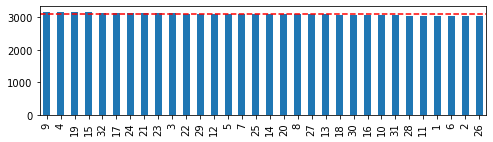

In [16]:
mean_invoices_store = data['EstoreID'].value_counts().mean()
print('There are', data.EstoreID.nunique(), 'stores')
data['EstoreID'].value_counts().plot(kind='bar',figsize=(8, 2))
plt.axhline(y=mean_invoices_store, color='r', linestyle='--')
#plt.savefig('estores_entries.png', dpi=300, bbox_inches="tight")
plt.show()

Roughly 3000 entries for each store. 

#### Countries
From which countries the orders come and how many entries for each country?

In [17]:
print('There are', data.Country.nunique(), 'countries')
data['Country'].value_counts()

There are 13 countries


United Kingdom    9979
Germany           9397
France            9331
EIRE              9324
Spain             7990
Belgium           7944
Netherlands       7588
Switzerland       6892
Portugal          6632
Australia         6507
Norway            6256
Italy             6024
Sweden            5318
Name: Country, dtype: int64

Most entries are from UK, Germany, France, and EIRE. All the countries are in Europe, except Australia. 

Do the orders for each store come from all the countries or some stores are more present in specific countries?

In [18]:
print('The maximum number of invoices from a country for one e-store is', data.groupby(['EstoreID','Country']).size().max())
print('The minimum number of invoices from a country for one e-store is', data.groupby(['EstoreID','Country']).size().min())

The maximum number of invoices from a country for one e-store is 343
The minimum number of invoices from a country for one e-store is 149


Each e-store receive orders from each of the 13 countries, issuing between 149 and 343 invoices for each country. This means that each e-store is selling in a comparable way in each country.

#### Time period 
How long is the time period covered by the dataset?

In [19]:
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, cache=True)
print(data.InvoiceDate.max() - data.InvoiceDate.min())

373 days 04:05:00


In [20]:
print('Datafile starts with timepoint {}'.format(data.InvoiceDate.min()))
print('Datafile ends with timepoint {}'.format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:45:00
Datafile ends with timepoint 2011-12-09 12:50:00


#### Invoice number
How many different invoice numbers?

In [21]:
data.InvoiceNo.nunique()

7837

Since the amount of unique invoice numbers is much lower than the entries, most invoice numbers are repeated for several entries (i.e. one order contains several items and they all share the same InvoiceNo). 

#### Cancelled transactions
Cancelled transactions (or returns) are characterized by having an InvoiceNo starting with a "C" and a negative value at the Quantity variable.

In [22]:
data['Cancelled']=np.where(data.InvoiceNo.apply(lambda l: l[0]=='C'), True, False)
data.Cancelled.value_counts() / data.shape[0] * 100

False    97.174891
True      2.825109
Name: Cancelled, dtype: float64

2.82 % of all entries are cancelled orders. Is there a correspondant entry for each cancelled order? If so, when predicting sales we should remove both the cancellation and the original order.

In [23]:
data_clean = data.copy()

cancelled_orders = []; 

for v in data.InvoiceNo:
    if 'c' in v.lower():
        cancelled_orders.append(v[1:])

orders_to_remove = [];        
for v in data.InvoiceNo:
    if v in cancelled_orders:
        orders_to_remove.append(v)


In [24]:
print(len(cancelled_orders))
print(len(orders_to_remove))

2802
0


The original orders corresponding to the cancelled orders are not in the dataset.

#### Stockcodes
How many stockcodes are there and which codes are most common?

In [25]:
data['StockCode'].value_counts().describe()

count    1992.000000
mean        3.317771
std         4.131311
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        80.000000
Name: StockCode, dtype: float64

In [26]:
print('There are',data.StockCode.nunique(),'different stock codes.')
mean_invoices_stock = data['StockCode'].value_counts().mean()
print('Each stock code appears at least',data['StockCode'].value_counts().min(),'time, and maximumum',data['StockCode'].value_counts().max(), 'times.')
print('On average each code appears',mean_invoices_stock,'times.')
print('The median is',data['StockCode'].value_counts().median(),'times.')

There are 1992 different stock codes.
Each stock code appears at least 1 time, and maximumum 80 times.
On average each code appears 3.3177710843373496 times.
The median is 2.0 times.


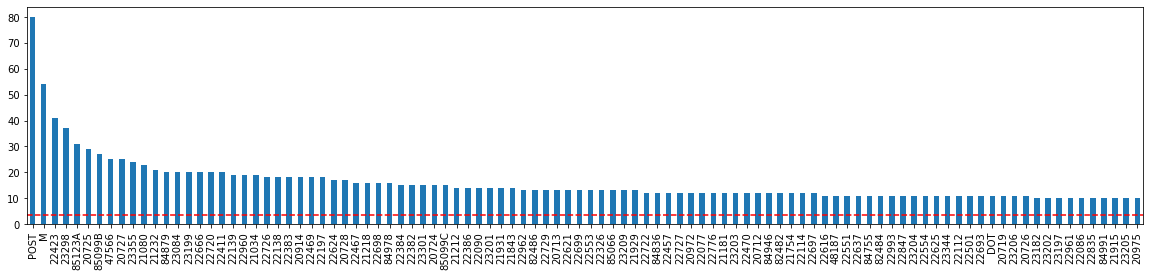

In [27]:
data['StockCode'].value_counts()[:100].plot(kind='bar',figsize=(20, 4))
plt.axhline(y=mean_invoices_stock, color='r', linestyle='--')
plt.show()

Are the most ordered items also the most cancelled? Maybe there are certain items that are returned more often than kept, so the shop could consider eliminating them from their catalogue. 

In [28]:
data.loc[data.Cancelled==True].groupby(['StockCode']).size().sort_values(ascending=False).iloc[0:10]

StockCode
M         33
22423     17
POST      12
47594A     9
22960      9
23298      9
22962      8
D          8
22553      7
22325      7
dtype: int64

#### Quantity

In [29]:
print('Min quantity:',data.Quantity.min(),' Max quantity:',data.Quantity.max())

Min quantity: -3167.0  Max quantity: 2400.0


In [30]:
data.Quantity.describe()

count    10298.000000
mean        11.184987
std         67.678009
min      -3167.000000
25%          1.000000
50%          4.000000
75%         12.000000
max       2400.000000
Name: Quantity, dtype: float64

In [31]:
data.Quantity.nunique()

130

In [32]:
data.Quantity.value_counts().sort_values(ascending=False)

 1.0      2170
 2.0      1293
 12.0     1251
 6.0       803
 4.0       677
          ... 
-140.0       1
 34.0        1
-39.0        1
 56.0        1
 480.0       1
Name: Quantity, Length: 130, dtype: int64

In [33]:
pos_quant = data.loc[data.Quantity > 0]
print('We can compute the revenue only for',pos_quant.shape[0],'entries, that is',pos_quant.shape[0]/ data.shape[0] * 100, '% of the data')

We can compute the revenue only for 9387 entries, that is 9.46441894698635 % of the data


In [34]:
zero_quant = data.loc[data.Quantity == 0] 
zero_quant.shape[0] # no entries with quantity == 0

0

In [35]:
neg_quant = data.loc[data.Quantity < 0]
neg_quant.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,EstoreID,Cancelled
0,2010-12-09 15:43:00,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1.0,2.95,15329.0,United Kingdom,20,True
72,2011-05-17 15:24:00,C553536,NaN,NaN,-2.0,8.15,14051.0,United Kingdom,15,True
175,2011-02-22 14:56:00,C544665,NaN,NaN,-2.0,2.95,12852.0,United Kingdom,11,True
332,2011-03-14 12:19:00,C546511,22801,ANTIQUE GLASS PEDESTAL BOWL,-1.0,3.75,12921.0,United Kingdom,3,True
426,2010-12-09 15:13:00,C538103,NaN,NaN,-2.0,8.50,17442.0,United Kingdom,23,True


In [36]:
neg_quant.shape[0]

911

911 entries with negative quantities. How many are cancelled orders?

In [37]:
returns = data.loc[(data.Cancelled==True) & (data.Quantity < 0)]
returns.shape[0] # 890

890

In [38]:
weird = data.loc[(data.Cancelled==True) & (data.Quantity > 0)]
weird.shape[0] 

0

890 of this 911 entries with negative quantities are cancelled orders or returns. The others must contain errors. At least there are no cancelled orders with quantity > 0. 

Let's look at the entries with positive quantity.

In [39]:
data_quantity = data.loc[data.Quantity > 0].copy()
data_quantity.drop(['Cancelled'],axis=1,inplace=True)

print('Min quantity is', data_quantity.Quantity.min())
print('Total', data_quantity.Quantity.nunique(), 'possible values')

Min quantity is 1.0
Total 89 possible values


<AxesSubplot:>

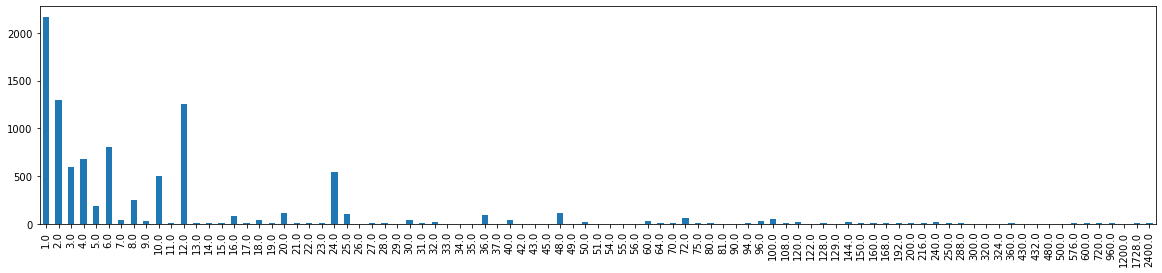

In [40]:
# this plot works only with a large screen
data_quantity['Quantity'].value_counts().sort_index().plot(kind='bar',figsize=(20, 4))

<AxesSubplot:>

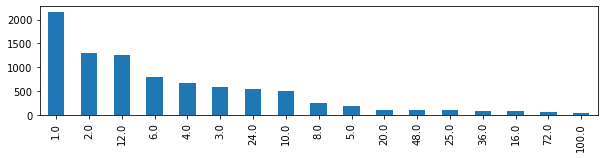

In [41]:
data_quantity['Quantity'].value_counts()[:100].plot(kind='bar',figsize=(10, 2))

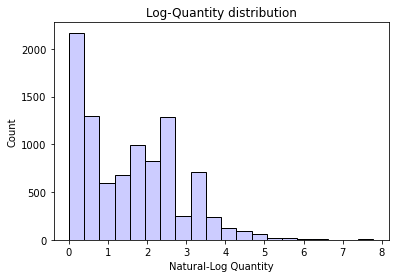

In [42]:
fig, ax = plt.subplots()
sns.histplot(np.log(data_quantity.Quantity), ax=ax, bins=20, kde=False, color="blue", alpha=0.2);
ax.set_title("Log-Quantity distribution")
ax.set_xlabel("Natural-Log Quantity");

The orders with large amount of a product might be retailers.

#### Customers

In [43]:
print('There are',data.CustomerID.nunique(),'customers')

data['CustomerID'].value_counts().describe()

There are 2598 customers


count    2598.000000
mean       36.539646
std       235.479350
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      6716.000000
Name: CustomerID, dtype: float64

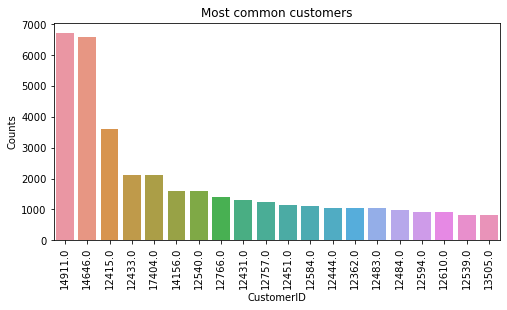

In [44]:
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(8,4))
sns.barplot(x = customer_counts.index, y = customer_counts.values, order = customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Most common customers");
plt.xticks(rotation=90);
#plt.savefig('customer_counts.png', dpi=300, bbox_inches="tight")
plt.show()

In [45]:
print('There are',data.CustomerID.nunique(),'customers')

There are 2598 customers


In [46]:
data['CustomerID'].value_counts().describe()

count    2598.000000
mean       36.539646
std       235.479350
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      6716.000000
Name: CustomerID, dtype: float64

### Sales in time
We create a copy of the data called data_sales from which we remove the sales with negative quantities (cancelled orders and errors) and drop all the variables with missing values.

In [47]:
data_sales = data.loc[(data.Cancelled==False)&((data.Quantity < 0) == False)].copy()
data_sales.drop(['StockCode','Description','Quantity','CustomerID','Cancelled'],axis=1,inplace=True)
data_sales.head()

,InvoiceDate,InvoiceNo,UnitPrice,Country,EstoreID
1,2011-12-09 09:07:00,581480,4.95,United Kingdom,20
2,2011-12-07 12:55:00,581132,4.95,United Kingdom,1
3,2011-06-23 14:11:00,557892,6.35,United Kingdom,17
4,2011-01-25 14:01:00,542115,2.08,United Kingdom,6
5,2011-12-01 11:51:00,580024,0.39,United Kingdom,32


In [48]:
data_sales.shape # (96359, 5)

(96359, 5)

In [49]:
data_sales['Year'] = data_sales.InvoiceDate.dt.year
data_sales['Quarter'] = data_sales.InvoiceDate.dt.quarter
data_sales['Month'] = data_sales.InvoiceDate.dt.month
data_sales['Week'] = data_sales.InvoiceDate.dt.isocalendar().week
data_sales['Weekday'] = data_sales.InvoiceDate.dt.weekday
data_sales['Day'] = data_sales.InvoiceDate.dt.day
data_sales['Dayofyear'] = data_sales.InvoiceDate.dt.dayofyear
data_sales['Hour'] = data_sales.InvoiceDate.dt.hour
data_sales['Date'] = pd.to_datetime(data_sales[['Year', 'Month', 'Day']])

In [50]:
data_sales.head()

,InvoiceDate,InvoiceNo,UnitPrice,Country,EstoreID,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Hour,Date
1,2011-12-09 09:07:00,581480,4.95,United Kingdom,20,2011,4,12,49,4,9,343,9,2011-12-09
2,2011-12-07 12:55:00,581132,4.95,United Kingdom,1,2011,4,12,49,2,7,341,12,2011-12-07
3,2011-06-23 14:11:00,557892,6.35,United Kingdom,17,2011,2,6,25,3,23,174,14,2011-06-23
4,2011-01-25 14:01:00,542115,2.08,United Kingdom,6,2011,1,1,4,1,25,25,14,2011-01-25
5,2011-12-01 11:51:00,580024,0.39,United Kingdom,32,2011,4,12,48,3,1,335,11,2011-12-01


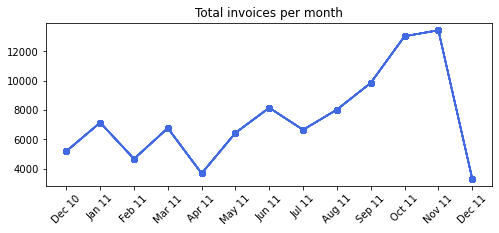

In [51]:
fig, ax= plt.subplots(figsize=(8,3))
yearmonth = ['Dec 10', 'Jan 11', 'Feb 11', 'Mar 11', 'Apr 11', 'May 11',
             'Jun 11', 'Jul 11', 'Aug 11', 'Sep 11', 'Oct 11', 'Nov 11', 'Dec 11']
data_sales.groupby(["Year", "Month"]).count().plot(ax= ax, marker='o', legend= False, c="royalblue");
ax.set_xticks(np.arange(0, len(yearmonth)))
ax.set_xticklabels(yearmonth, rotation=45)
ax.set_xlabel('')
ax.set_title('Total invoices per month');

#plt.savefig('invoices_month.png', dpi=300, bbox_inches="tight")
plt.show()

Keep in mind that for Dec-2011 we have just 9 days.

Let's remove those 9 days from the dataframe data_sales and use them to compare them with the same days in Dec-2010.

In [52]:
dec2011_sales = data_sales.loc[data_sales['Date'] > pd.to_datetime('2011-11-30')]
print('There are', dec2011_sales.shape[0],'entries for the first 9 days of December 2011')
dec2011_sales.head()

There are 3342 entries for the first 9 days of December 2011


,InvoiceDate,InvoiceNo,UnitPrice,Country,EstoreID,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Hour,Date
1,2011-12-09 09:07:00,581480,4.95,United Kingdom,20,2011,4,12,49,4,9,343,9,2011-12-09
2,2011-12-07 12:55:00,581132,4.95,United Kingdom,1,2011,4,12,49,2,7,341,12,2011-12-07
5,2011-12-01 11:51:00,580024,0.39,United Kingdom,32,2011,4,12,48,3,1,335,11,2011-12-01
26,2011-12-06 11:24:00,580808,0.39,United Kingdom,4,2011,4,12,49,1,6,340,11,2011-12-06
46,2011-12-05 14:40:00,580677,2.49,United Kingdom,25,2011,4,12,49,0,5,339,14,2011-12-05


In [53]:
dec2010_sales = data_sales.loc[data_sales['Date'] < pd.to_datetime('2010-12-10')]
print('There are', dec2010_sales.shape[0],'entries for the first 9 days of December 2010')

There are 2641 entries for the first 9 days of December 2010


In [54]:
y1 = dec2010_sales.groupby('Day').InvoiceNo.count()
y2 = dec2011_sales.groupby('Day').InvoiceNo.count()
#print(y1)
#print(y2)

In [55]:
y1.describe()

count      8.000000
mean     330.125000
std      214.825137
min       59.000000
25%      158.000000
50%      313.500000
75%      476.750000
max      666.000000
Name: InvoiceNo, dtype: float64

In [56]:
y2.describe()

count      8.000000
mean     417.750000
std      234.752605
min      185.000000
25%      219.750000
50%      372.000000
75%      561.750000
max      861.000000
Name: InvoiceNo, dtype: float64

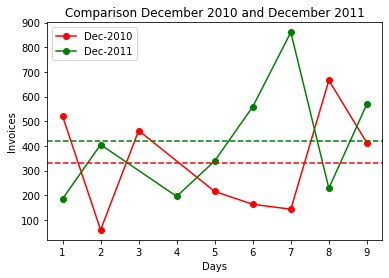

In [57]:
plt.figure(figsize=(6,4))
plt.plot(y1, color='r', marker='o', label='Dec-2010')
plt.plot(y2, color='g', marker='o', label='Dec-2011')

plt.axhline(y=y1.mean(), color='r', linestyle='--')
plt.axhline(y=y2.mean(), color='g', linestyle='--')

plt.xlabel("Days")
plt.ylabel("Invoices")
plt.title("Comparison December 2010 and December 2011")

plt.legend()
#plt.savefig('dec10dec11_increase.png', dpi=300, bbox_inches="tight")
plt.show()

In [58]:
print('The mean value of issued invoices in Dec 2011 is increased of',(y2.mean()-y1.mean())/y1.mean() * 100,'% from December 2010')

The mean value of issued invoices in Dec 2011 is increased of 26.54297614539947 % from December 2010


Let's get some insights from the sales of the first year (without Dec 2011).

In [59]:
data_sales = data_sales.loc[data_sales['Date'] < pd.to_datetime('2011-12-01')]

In [60]:
data_sales.head()

,InvoiceDate,InvoiceNo,UnitPrice,Country,EstoreID,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Hour,Date
3,2011-06-23 14:11:00,557892,6.35,United Kingdom,17,2011,2,6,25,3,23,174,14,2011-06-23
4,2011-01-25 14:01:00,542115,2.08,United Kingdom,6,2011,1,1,4,1,25,25,14,2011-01-25
6,2011-01-27 10:30:00,542277,5.95,United Kingdom,9,2011,1,1,4,3,27,27,10,2011-01-27
7,2011-03-08 12:30:00,545979,0.85,United Kingdom,3,2011,1,3,10,1,8,67,12,2011-03-08
8,2011-03-04 10:24:00,545590,0.42,United Kingdom,15,2011,1,3,9,4,4,63,10,2011-03-04


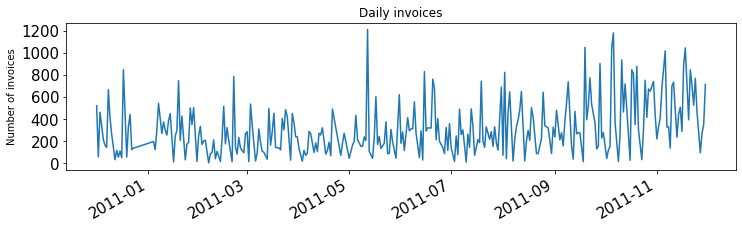

In [61]:
yearmonth = ['Dec 10', 'Jan 11', 'Feb 11', 'Mar 11', 'Apr 11', 'May 11',
             'Jun 11', 'Jul 11', 'Aug 11', 'Sep 11', 'Oct 11', 'Nov 11', 'Dec 11']

data_sales.groupby('Date').count().plot(y='InvoiceNo', legend= False, fontsize=15, 
                                        figsize=(12,3), 
                                        ylabel='Number of invoices', xlabel='',
                                        title="Daily invoices");
#plt.savefig('invoices_daily.png', dpi=300, bbox_inches="tight")
plt.show()

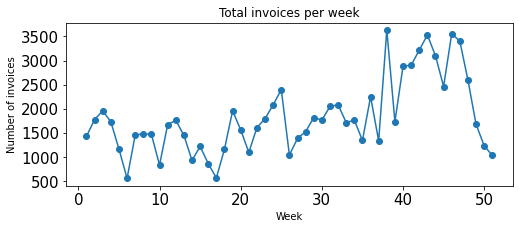

In [62]:
data_sales.groupby('Week').count().plot(y='InvoiceNo', legend= False, fontsize=15, figsize=(8,3), marker='o',
                                        ylabel='Number of invoices',title="Total invoices per week");
plt.show()

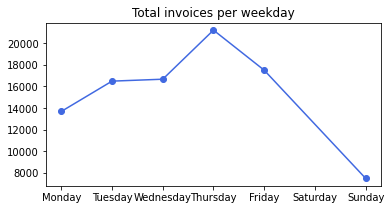

In [63]:
fig, ax= plt.subplots(figsize=(6,3))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

data_sales.groupby("Weekday").InvoiceNo.count().plot(ax=ax,marker='o',color='royalblue',legend= False);
ax.set_xticks(np.arange(0,7))
ax.set_xticklabels(weekdays);
ax.set_xlabel("") 
ax.set_title("Total invoices per weekday");
#plt.savefig('invoices_weeekday.png', dpi=300, bbox_inches="tight")
plt.show()

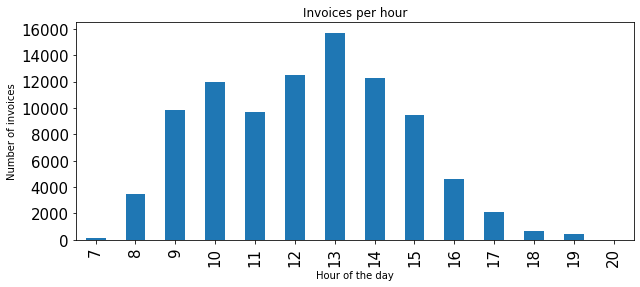

In [64]:
data_sales.groupby("Hour").count().plot(y='InvoiceNo', kind='bar', legend= False,
                                        fontsize=15, figsize=(10,4), xlabel='Hour of the day', ylabel='Number of invoices',
                                        title="Invoices per hour");

This insights could be presented as percentages.

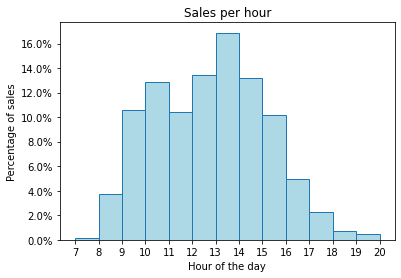

In [65]:
fig, axs = plt.subplots(figsize=(6, 4));

axs.hist(data_sales['Hour'], bins=13, color='lightblue', edgecolor='tab:blue', density=True)
axs.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xticks(range(7, 21))
plt.ylabel("Percentage of sales")
plt.xlabel("Hour of the day")
plt.title("Sales per hour");

#plt.savefig('hist_hours_sales.png', dpi=300, bbox_inches="tight")